### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import time
pd.options.display.max_columns = 50

### Import the data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape, test.shape

((891, 12), (418, 11))

### Correlation Analysis

In [3]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


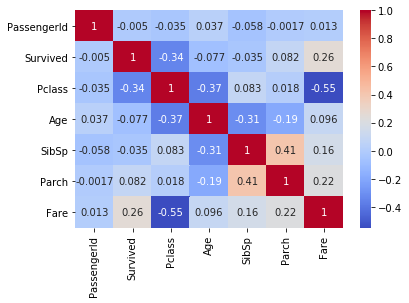

In [4]:
sn.heatmap(train.corr(), cmap='coolwarm', annot=True)

In [5]:
train.corr()['Survived'].abs().sort_values(ascending=False) # correlations with target variable

Survived       1.000000
Pclass         0.338481
Fare           0.257307
Parch          0.081629
Age            0.077221
SibSp          0.035322
PassengerId    0.005007
Name: Survived, dtype: float64

## Train data preparation and feature engineering

#### Feature engineering

In [6]:
train['Sex'] = train['Sex'].map({'male':1, 'female':0})
dummies = pd.get_dummies(train[['Embarked', 'SibSp', 'Parch']].astype(object), prefix=['Embarked', 'Sibsp', 'Parch'])
train = pd.concat([train, dummies], axis=1)

In [7]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_C,Embarked_Q,Embarked_S,Sibsp_0,Sibsp_1,Sibsp_2,Sibsp_3,Sibsp_4,Sibsp_5,Sibsp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


#### Correlation analysis 2.0

In [8]:
train.corr()['Survived'].abs().sort_values(ascending=False) 
# Lets take variables with absolute correlation value at least > 0.05
# Also we dont include whole dummy variables groups to evade "dummy trap" and issues with multicollinearity

Survived       1.000000
Sex            0.543351
Pclass         0.338481
Fare           0.257307
Sibsp_1        0.173076
Embarked_C     0.168240
Embarked_S     0.155660
Parch_0        0.147408
Parch_1        0.134174
Sibsp_0        0.115867
Parch          0.081629
Age            0.077221
Parch_2        0.075020
Sibsp_8        0.070234
Sibsp_4        0.064123
Sibsp_5        0.059292
Parch_4        0.053002
Sibsp_3        0.037215
SibSp          0.035322
Parch_3        0.033391
Sibsp_2        0.029796
Parch_5        0.028398
Parch_6        0.026456
PassengerId    0.005007
Embarked_Q     0.003650
Name: Survived, dtype: float64

In [9]:
model_vars = train.corr()['Survived'].abs().sort_values(ascending=False)[:17].index
model_vars = model_vars.drop(['Survived', 'Parch']) # drop the target and Parch

In [10]:
corr = train.corr()
corr[corr.abs() > 0.85].fillna(0).style.apply(lambda x: ["background: green" if abs(x) > 0.85 else "" for x in x], axis=1)
# as Parch was dropped it seems that there is no problem with multicollinearity here

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sibsp_0,Sibsp_1,Sibsp_2,Sibsp_3,Sibsp_4,Sibsp_5,Sibsp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
PassengerId,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Survived,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Pclass,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sex,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Age,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SibSp,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Parch,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Fare,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Embarked_C,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Embarked_Q,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Missing values

In [11]:
train.isna().sum()[train.isna().sum() > 0] 
# we will ignore variables Cabin and Embarked. They won't take part in the model variables

Age         177
Cabin       687
Embarked      2
dtype: int64

In [12]:
train['Age'] = train['Age'].fillna(train['Age'].median())

## Test data preparation

In [13]:
test.isna().sum()[test.isna().sum() > 0]

Age       86
Fare       1
Cabin    327
dtype: int64

In [14]:
test['Sex'] = test['Sex'].map({'male': 1, 'female': 0})
dummies = pd.get_dummies(test[['Embarked', 'SibSp', 'Parch']].astype(object), prefix=['Embarked', 'Sibsp', 'Parch'])
test = pd.concat([test, dummies], axis=1)
test['Age'] = test['Age'].fillna(test['Age'].median())
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())

## Train and test data preprocessing

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
X_train = train[model_vars]
X_test = test[model_vars]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = train['Survived'].values
X_train.shape, y_train.shape, X_test.shape,

((891, 15), (891,), (418, 15))

## Models training

### Import of models

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

### General pipeline

#### Import of accuracy and cross-validation functions

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score

In [19]:
random_state = 13
# models to train
models = [DecisionTreeClassifier(random_state=random_state), RandomForestClassifier(random_state=random_state),
          LogisticRegression(random_state=random_state), SVC(random_state=random_state),
          KNeighborsClassifier(), # dont have random state. At least it did not work
          CatBoostClassifier(random_state=random_state, verbose=0),
          XGBClassifier(random_state=random_state), LGBMClassifier(random_state=random_state)]
# parameters to put in GridSearchCV for each model
params_grids = {'DecisionTreeClassier':{'criterion': ['gini', 'entropy']}, 
               'RandomForestClassifier':{'n_estimators': [5, 15, 50, 100, 200, 300], 'criterion': ['gini', 'entropy']},
               'LogisticRegression': {'C': [1, 5, 100, 500, 1000, 10000]}, 
               'SVC': {'C': [1, 5, 100, 500, 1000], 'kernel': ['rbf', 'sigmoid', 'poly']},
               'KNeighborsClassifier': {'n_neighbors':[x for x in range(1, 26)], 'weights': ['uniform', 'distance']},
               'CatBoostClassifier': {'iterations': [x for x in range(5, 31, 5)],
                                      'learning_rate': [0.01, 0.03,  0.05, 0.07, 0.1]},
               'XGBClassifier': {'iteration': [x for x in range(5, 31, 5)],
                                 'learning_rate':[0.01, 0.03,  0.05, 0.07, 0.1]}, 
               'LGBMClassifier': {'iteration': [x for x in range(5, 31, 5)],
                                 'learning_rate':[0.01, 0.03,  0.05, 0.07, 0.1]}}
# Cross-validation parameters
kf = KFold(n_splits=5, shuffle=True)

#### Main loop for models training and cross-validation

In [24]:
best_scores = {'DecisionTreeClassier':0, 'RandomForestClassifier':0, 'LogisticRegression':0, 
                   'SVC': 0, 'KNeighborsClassifier':0, 'CatBoostClassifier':0, 
                   'XGBClassifier':0, 'LGBMClassifier':0}
best_models = {'DecisionTreeClassier':0, 'RandomForestClassifier':0, 'LogisticRegression':0, 
                   'SVC': 0, 'KNeighborsClassifier':0, 'CatBoostClassifier':0, 
                   'XGBClassifier':0, 'LGBMClassifier':0}

for model, param_grid, estimator in zip(models, params_grids, best_scores):
    start = time.time()
    gs = GridSearchCV(model, params_grids[param_grid], scoring='accuracy', cv=kf, verbose=0, n_jobs=6)
    gs.fit(X_train, y_train)
    best_scores[estimator] = gs.best_score_
    best_models[estimator] = gs.best_estimator_
    print('Training', estimator, 'on 5 Kfold cv and params from param_grid took', round(time.time() - start, 2),
          'seconds')

Training DecisionTreeClassier  on 5 Kfold cv and params from param_grid took 2.59 seconds
Training RandomForestClassifier  on 5 Kfold cv and params from param_grid took 8.59 seconds
Training LogisticRegression  on 5 Kfold cv and params from param_grid took 0.24 seconds
Training SVC  on 5 Kfold cv and params from param_grid took 4.72 seconds
Training KNeighborsClassifier  on 5 Kfold cv and params from param_grid took 1.43 seconds
Training CatBoostClassifier  on 5 Kfold cv and params from param_grid took 61.86 seconds
Training XGBClassifier  on 5 Kfold cv and params from param_grid took 9.15 seconds
Training LGBMClassifier  on 5 Kfold cv and params from param_grid took 4.87 seconds


In [25]:
best_scores

{'DecisionTreeClassier': 0.7845395769254913,
 'RandomForestClassifier': 0.8024919967359236,
 'LogisticRegression': 0.795712761283033,
 'SVC': 0.8148264390182662,
 'KNeighborsClassifier': 0.8046952482581131,
 'CatBoostClassifier': 0.8159249262444291,
 'XGBClassifier': 0.8159312033142928,
 'LGBMClassifier': 0.8249262444291003}

#### Answers writing to the files

In [26]:
for i in best_models:
    if i != 'CatBoostClassifier':
        preds = best_models[i].predict(X_test)
        submit = pd.DataFrame(test['PassengerId'])
        submit['Survived'] = preds
        submit.to_csv(i + '_many_vars_GridSearch_CV.csv', index=False)
    else:
        preds = best_models[i].predict(X_test)
        submit = pd.DataFrame(test['PassengerId'])
        submit['Survived'] = preds
        submit['Survived'] = submit['Survived'].astype(int)
        submit.to_csv(i + '_many_vars_GridSearch_CV.csv', index=False)

## In the end the best model performance on the test dataset was achieved via CatBoostClassifier model with score of 0.78229. TOP-25% on Kaggle leaderboard